## Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [2]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2019-09-01", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp.head()

^N225                                                   \
                    Open          High           Low         Close Volume   
Date                                                                        
1994-01-06           NaN           NaN           NaN           NaN    NaN   
1994-01-07  17842.980469  18131.410156  17787.480469  18124.009766    0.0   
1994-01-10  18186.519531  18567.060547  18186.519531  18443.439453    0.0   
1994-01-11  18481.849609  18671.669922  18373.039062  18485.250000    0.0   
1994-01-12  18447.339844  18807.080078  18301.929688  18793.880859    0.0   

                 ^GSPC                                                   \
                  Open        High         Low       Close       Volume   
Date                                                                      
1994-01-06  467.549988  469.000000  467.019989  467.119995  365960000.0   
1994-01-07  467.089996  470.260010  467.029999  469.899994  324920000.0   
1994-01-10  469.899994  475.269989  469.549988  475.269989  319490000.0   
1994-01-11  475.269989  475.279999  473.269989  474.130005  305490000.0   
1994-01-12  474.130005  475.059998  472.140015  474.170013  310690000.0   

                 ^GDAXI                                                \
                   Open         High          Low        Close Volume   
Date                                                                    
1994-01-06  2228.090088  2228.489990  2206.459961  2220.629883    0.0   
1994-01-07  2218.959961  2227.639893  2201.820068  2224.949951    0.0   
1994-01-10  2231.840088  2238.010010  2222.000000  2225.000000    0.0   
1994-01-11  2225.429932  2235.610107  2225.179932  2228.100098    0.0   
1994-01-12  2227.120117  2227.790039  2182.060059  2182.060059    0.0   

                  ^FTSE                                                
                   Open         High          Low        Close Volume  
Date                                                                   
1994-01-06  3355.300049  3407.699951  3355.300049  3403.000000    0.0  
1994-01-07  3401.399902  3446.800049  3398.699951  3446.000000    0.0  
1994-01-10  3465.699951  3468.100098  3430.000000  3440.600098    0.0  
1994-01-11  3442.500000  3442.500000  3413.500000  3413.800049    0.0  
1994-01-12  3394.800049  3402.399902  3372.000000  3372.000000    0.0

In [5]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [6]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')


In [7]:
df_comp.isnull().sum()

spx         233
dax         197
ftse        211
nikkei      390
dtype: int64

In [8]:
df_comp=df_comp.fillna(method='ffill')

In [9]:
df_comp.isnull().sum()

spx         0
dax         0
ftse        0
nikkei      0
dtype: int64

## Creating Returns

In [10]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [11]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [12]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [13]:
model_ar=ARIMA(df.ftse,order=(1,0,0))
results_ar=model_ar.fit()

## Simple Forecasting

In [14]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-08,1963.709961,9772.669922,6738.500000,15314.410156,-0.704880,-1.245695,-1.346653,-0.422839,-61.680354,794.952349,-59866.246313,-23.991315
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,40.639543,194.142222,16162.615912,-4.356898
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,-36.148835,433.166778,-67565.994483,-31.953776
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,12.871270,-170.245033,3318.342727,-19.549802
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,42.383382,-533.213704,53656.603796,49.681837


In [15]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date='2014-07-15'
end_date='2015-01-01'

In [16]:
df.pred=results_ar.predict(start=start_date,end=end_date)


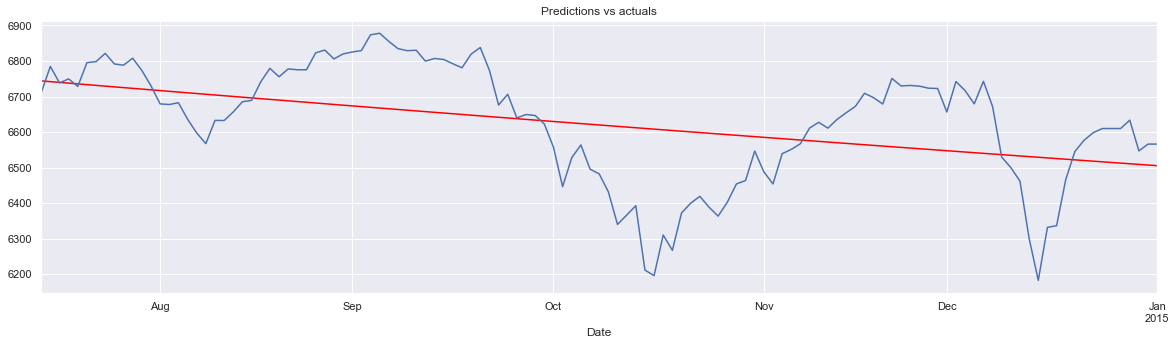

In [17]:
df.pred[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ftse[start_date:end_date].plot()
plt.title('Predictions vs actuals')
plt.show()

In [18]:
## we used df_test because predicted series is going to be maatched with df_test.ftse series and predicted series is taken from train data df
## we also found out that ar model is not the good estimator for non stationary data

### Using Returns Instead

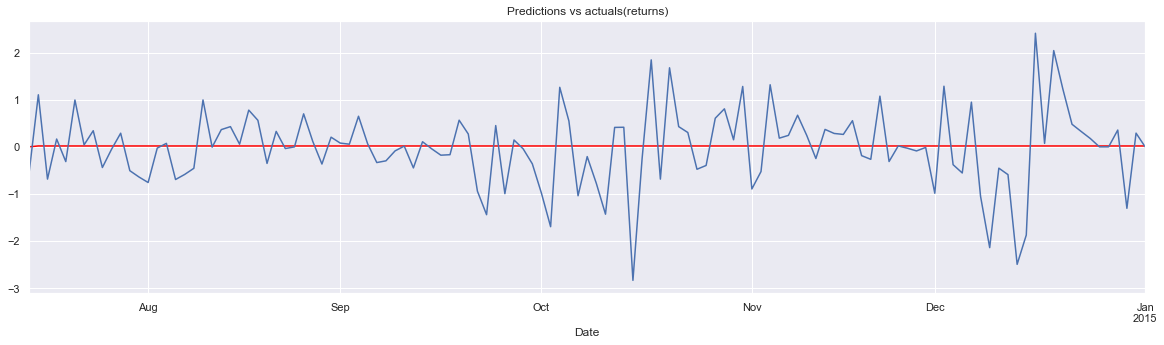

In [19]:
end_date='2015-01-01'

model_ret_ar=ARIMA(df.ret_ftse[1:],order=(1,0,0))
results_ret_ar=model_ret_ar.fit()

df_pred_ar=results_ret_ar.predict(start=start_date,end=end_date)

df_pred_ar[start_date:end_date].plot(figsize=(20,5),color='red')
df_test.ret_ftse[start_date:end_date].plot()
plt.title('Predictions vs actuals(returns)')
plt.show()

In [20]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(1, 0)   Log Likelihood               -8343.621
Method:                       css-mle   S.D. of innovations              1.151
Date:                Sun, 23 Jan 2022   AIC                          16693.241
Time:                        19:07:01   BIC                          16712.996
Sample:                    01-10-1994   HQIC                         16700.141
                         - 07-14-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0192      0.015      1.246      0.213      -0.011       0.049
ar.L1.ret_ftse    -0.0223      0.014     -1.634      0.102      -0.049       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -44.7719           +0.0000j           44.7719            0.5000
-----------------------------------------------------------------------------
"""

In [21]:
## since we see that both coefficients are insignificant that is they are not different from zero and so we see from plot that prediction is around or closely to zero

### MA

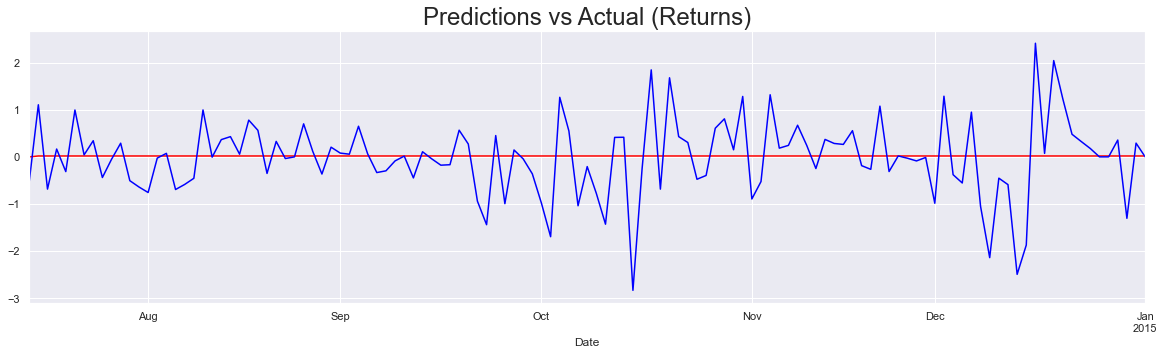

In [22]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### ARMA

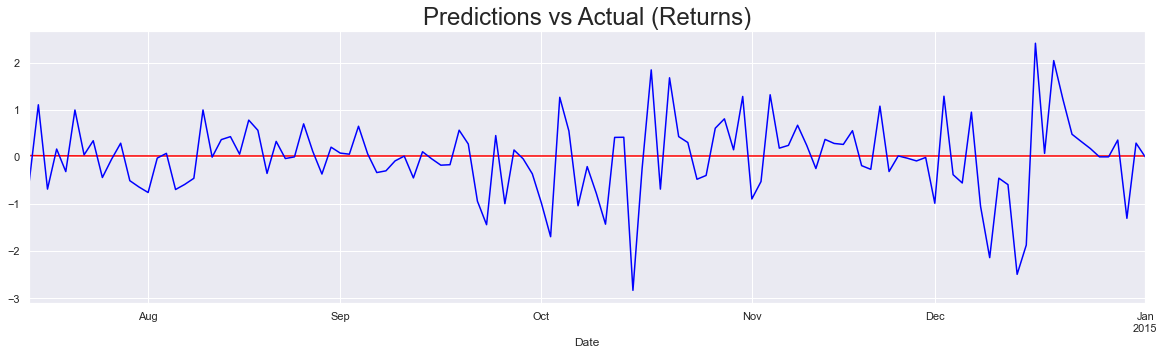

In [23]:
end_date = "2015-01-01"

model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date) 

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

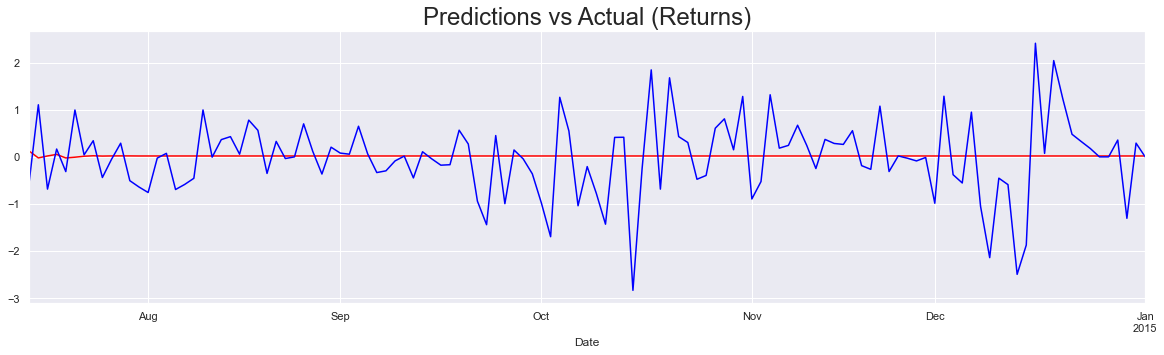

In [24]:
end_date = "2015-01-01"

model_ret_arma = ARIMA(df.ret_ftse[1:], order=(5,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date) 

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [25]:
df_pred_arma.head()

2014-07-15    0.123105
2014-07-16   -0.022235
2014-07-17    0.019555
2014-07-18    0.052018
2014-07-21   -0.022851
Freq: B, dtype: float64

In [26]:
df_pred_arma.tail()

2014-12-26    0.019224
2014-12-29    0.019224
2014-12-30    0.019224
2014-12-31    0.019224
2015-01-01    0.019224
Freq: B, dtype: float64

### ARMAX

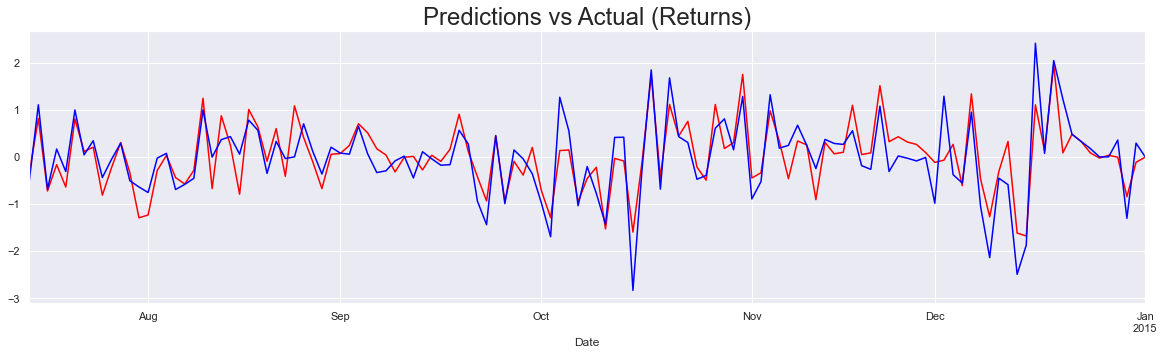

In [22]:
end_date = "2015-01-01"

model_ret_armax = ARIMA(df.ret_ftse[1:],exog=df[['ret_spx','ret_dax','ret_nikkei']][1:], order=(1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date,exog=df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [23]:
## we see that max models are great at analysing the but poor while forcasting the data because we dont have exog values for future and in this we used exog values of test data to validate the results so max models must be used to validate the test data but can't make forecasting as we dont have exog values for future

### SARMA

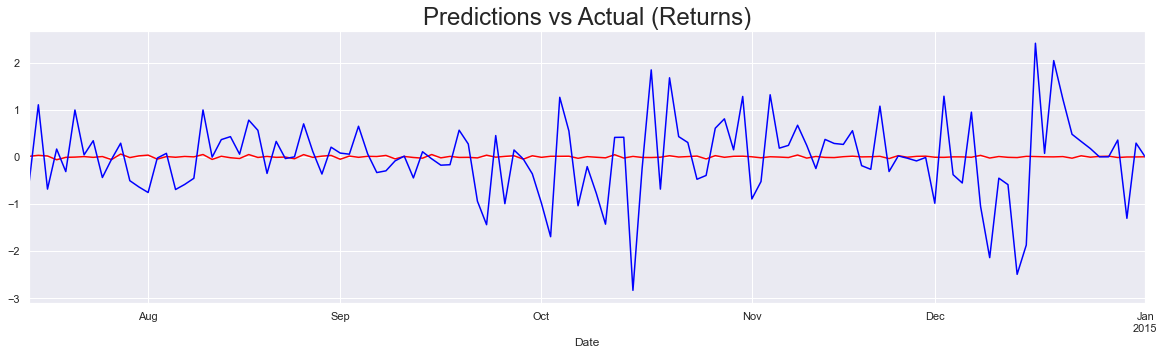

In [24]:
end_date = "2015-01-01"

model_ret_sarma = SARIMAX(df.ret_ftse[1:], order=(1,0,1),seasonal_order=(3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date) 

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARIMAX

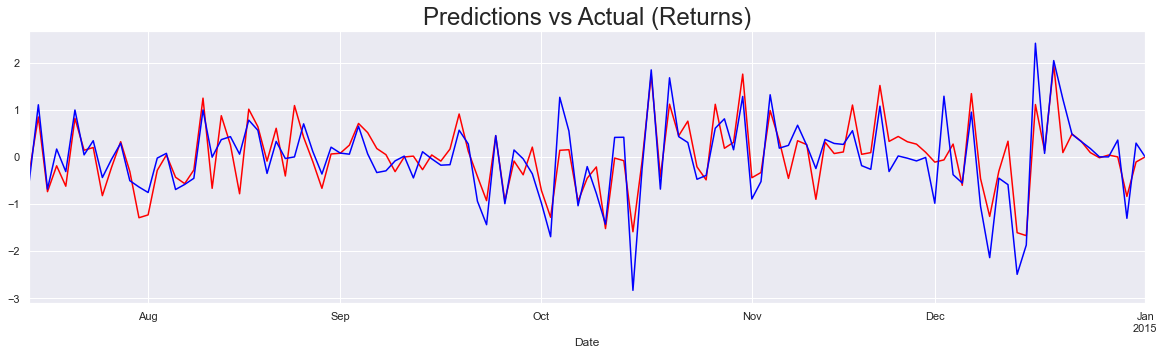

In [32]:
end_date = "2015-01-01"

model_ret_sarmax = SARIMAX(df.ret_ftse[1:],exog=df[['ret_spx','ret_dax','ret_nikkei']][1:], order=(1,0,1),seasonal_order=(3,0,2,5))
results_ret_sarmax = model_ret_sarmax.fit()

df_pred_sarimax = results_ret_sarmax.predict(start = start_date, end = end_date,exog=df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### Auto ARIMA

In [26]:
model_auto=auto_arima(df.ret_ftse[1:],exogenous=df[['ret_spx','ret_dax','ret_nikkei']][1:],m=5,max_p=5,max_q=5,max_P=5,max_Q=5)


In [27]:
df_auto_pred=pd.DataFrame(model_auto.predict(n_periods=len(df_test[start_date:end_date]),exogenous=df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date]),index=df_test[start_date:end_date].index)

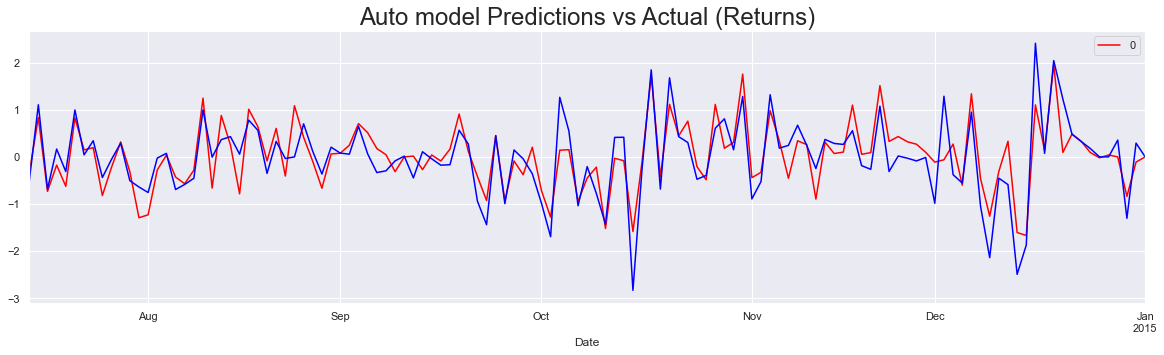

In [28]:
df_auto_pred.plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto model Predictions vs Actual (Returns)", size = 24)
plt.show()

### Comparing All the Models (Returns)

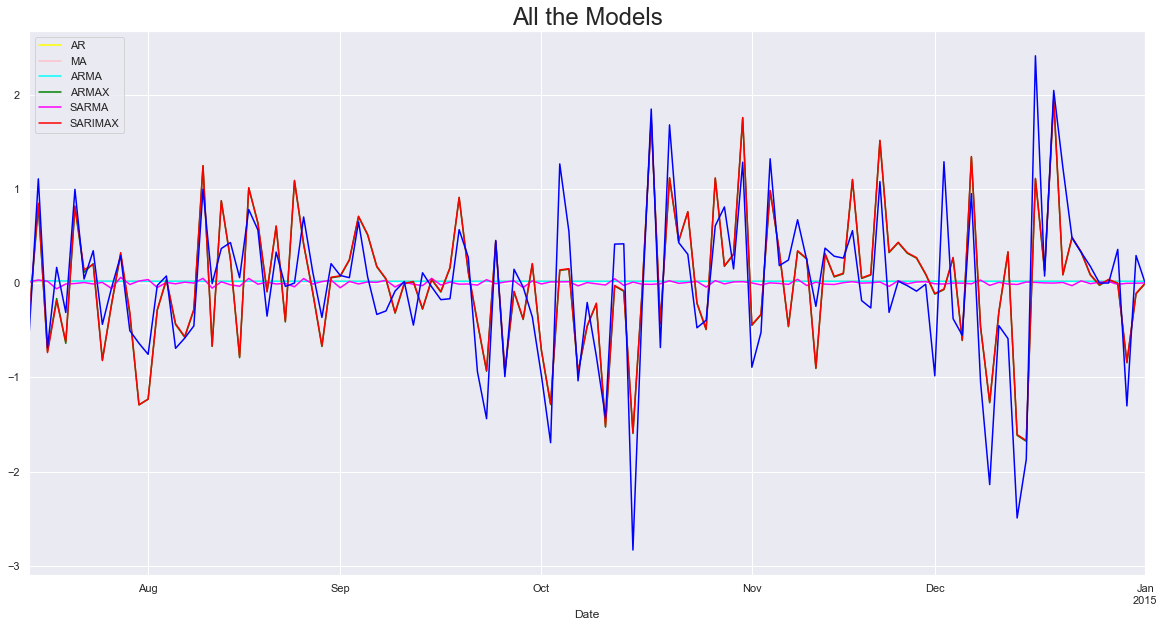

In [33]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()